In [33]:
!pip install torch-geometric

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg


# Data Preparation
def load_data():
    articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
    transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

    # Filter data
    item_freq = transactions.groupby('article_id')['customer_id'].nunique()
    user_freq = transactions.groupby('customer_id')['article_id'].nunique()

    items = item_freq[item_freq >= 100].index
    users = user_freq[user_freq >= 100].index

    filtered_df = transactions[transactions['article_id'].isin(items) & transactions['customer_id'].isin(users)]

    freq = filtered_df.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')
    GraphTravel_HM = filtered_df.merge(freq, on=['customer_id', 'article_id'], how='left')
    GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

    unique_customer_ids = GraphTravel_HM['customer_id'].unique()
    customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
    GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

    item_name_mapping = dict(zip(articles['article_id'], articles['prod_name']))

    return GraphTravel_HM, item_name_mapping


# GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


# Graph Data Preparation
def prepare_graph_data(G):
    nodes = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    edge_index = []
    for edge in G.edges():
        edge_index.append([node_to_idx[edge[0]], node_to_idx[edge[1]]])
        edge_index.append([node_to_idx[edge[1]], node_to_idx[edge[0]]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.eye(len(nodes), dtype=torch.float)

    return x, edge_index, node_to_idx


def generate_embeddings(GraphTravel_HM):
    G = nx.Graph()

    for _, row in GraphTravel_HM.iterrows():
        G.add_node(row['customer_id'], type='user')
        G.add_node(row['article_id'], type='item')
        G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

    x, edge_index, node_to_idx = prepare_graph_data(G)

    input_dim = x.size(1)
    hidden_dim = 128
    output_dim = 128

    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(x, edge_index)

        # Loss: Compare output embeddings for connected nodes
        loss = 0
        for edge in edge_index.t():
            node_u, node_v = edge
            loss += F.mse_loss(out[node_u], out[node_v])

        loss /= edge_index.size(1)  # Normalize by the number of edges
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        final_embeddings = model(x, edge_index)

    # Convert embeddings to a dictionary
    embeddings = {node: final_embeddings[node_to_idx[node]].numpy() for node in G.nodes()}
    return embeddings



# Recommendation Functions
def get_rated_items(user_id, df):
    return set(df[df['customer_id'] == user_id]['article_id'])


def calculate_similarities(user_id, df, embeddings):
    rated_items = get_rated_items(user_id, df)
    user_embedding = embeddings[user_id]

    item_similarities = []
    for item_id in set(df['article_id']):
        if item_id not in rated_items and item_id in embeddings:
            item_embedding = embeddings[item_id]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities


def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(20, 10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        print(f"- Item {item_id}: {item_name_mapping.get(item_id, 'Unknown')}", end='')
        if show_similarity:
            print(f" with similarity score: {similarity:.4f}")
        else:
            print()
        img_path = f"../input/h-and-m-personalized-fashion-recommendations/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()


def recommend_items(user_id, df, embeddings, item_name_mapping, num_items=5):
    rated_items = get_rated_items(user_id, df)
    print(f"User {user_id} has purchased:")
    show_images([(item_id, 0) for item_id in list(rated_items)[:5]], item_name_mapping, min(len(rated_items), 5))

    item_similarities = calculate_similarities(user_id, df, embeddings)
    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]

    print(f"\nRecommended items for user {user_id}:")
    show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)


# Main Execution
GraphTravel_HM, item_name_mapping = load_data()
embeddings = generate_embeddings(GraphTravel_HM)
recommend_items(45, GraphTravel_HM, embeddings, item_name_mapping, num_items=5)


In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity

# Data Loading and Preprocessing
def load_and_preprocess_data(articles_path, customers_path, transactions_path):
    articles = pd.read_csv(articles_path)
    customers = pd.read_csv(customers_path)
    transactions = pd.read_csv(transactions_path)

    # Filter items and users with sufficient interactions
    item_freq = transactions.groupby('article_id')['customer_id'].nunique()
    user_freq = transactions.groupby('customer_id')['article_id'].nunique()

    items = item_freq[item_freq >= 100].index
    users = user_freq[user_freq >= 100].index

    filtered_df = transactions[
        transactions['article_id'].isin(items) & 
        transactions['customer_id'].isin(users)
    ]

    # Calculate interaction frequency
    freq = filtered_df.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')
    GraphTravel_HM = filtered_df.merge(freq, on=['customer_id', 'article_id'], how='left')
    GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

    # Create mapping for customer and article IDs
    unique_customer_ids = GraphTravel_HM['customer_id'].unique()
    customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
    GraphTravel_HM['customer_id_mapped'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

    # Create item name mapping
    item_name_mapping = dict(zip(articles['article_id'], articles['prod_name']))

    return GraphTravel_HM, item_name_mapping

# Graph Construction
def create_interaction_graph(GraphTravel_HM):
    G = nx.Graph()

    for index, row in GraphTravel_HM.iterrows():
        G.add_node(row['customer_id_mapped'], type='user')
        G.add_node(row['article_id'], type='item')
        G.add_edge(row['customer_id_mapped'], row['article_id'], weight=row['frequency'])

    return G

# GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Graph Data Preparation
def prepare_graph_data(G):
    nodes = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    edge_index = []
    for edge in G.edges():
        edge_index.append([node_to_idx[edge[0]], node_to_idx[edge[1]]])
        edge_index.append([node_to_idx[edge[1]], node_to_idx[edge[0]]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.eye(len(nodes), dtype=torch.float)

    return x, edge_index, node_to_idx

# Generate Embeddings
def generate_embeddings(G, input_dim, hidden_dim, output_dim):
    x, edge_index, node_to_idx = prepare_graph_data(G)

    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(x, edge_index)
        loss = F.mse_loss(out, x)
        loss.backward()
        optimizer.step()

    embeddings = {node: out[node_to_idx[node]].detach().numpy() for node in G.nodes()}
    return embeddings

# Recommendation Function
def recommend_items(target_customer, GraphTravel_HM, embeddings, item_name_mapping, num_items=5):
    # Example placeholder: actual implementation depends on your specific requirements
    customer_embedding = embeddings.get(target_customer)
    
    if customer_embedding is None:
        print(f"No embedding found for customer {target_customer}")
        return []
    
    # Compare customer embedding with item embeddings
    item_similarities = {}
    for item in set(GraphTravel_HM['article_id']):
        if item in embeddings:
            similarity = cosine_similarity([customer_embedding], [embeddings[item]])[0][0]
            item_similarities[item] = similarity
    
    # Sort items by similarity and get top recommendations
    recommended_items = sorted(item_similarities, key=item_similarities.get, reverse=True)[:num_items]
    
    return [item_name_mapping.get(item, item) for item in recommended_items]


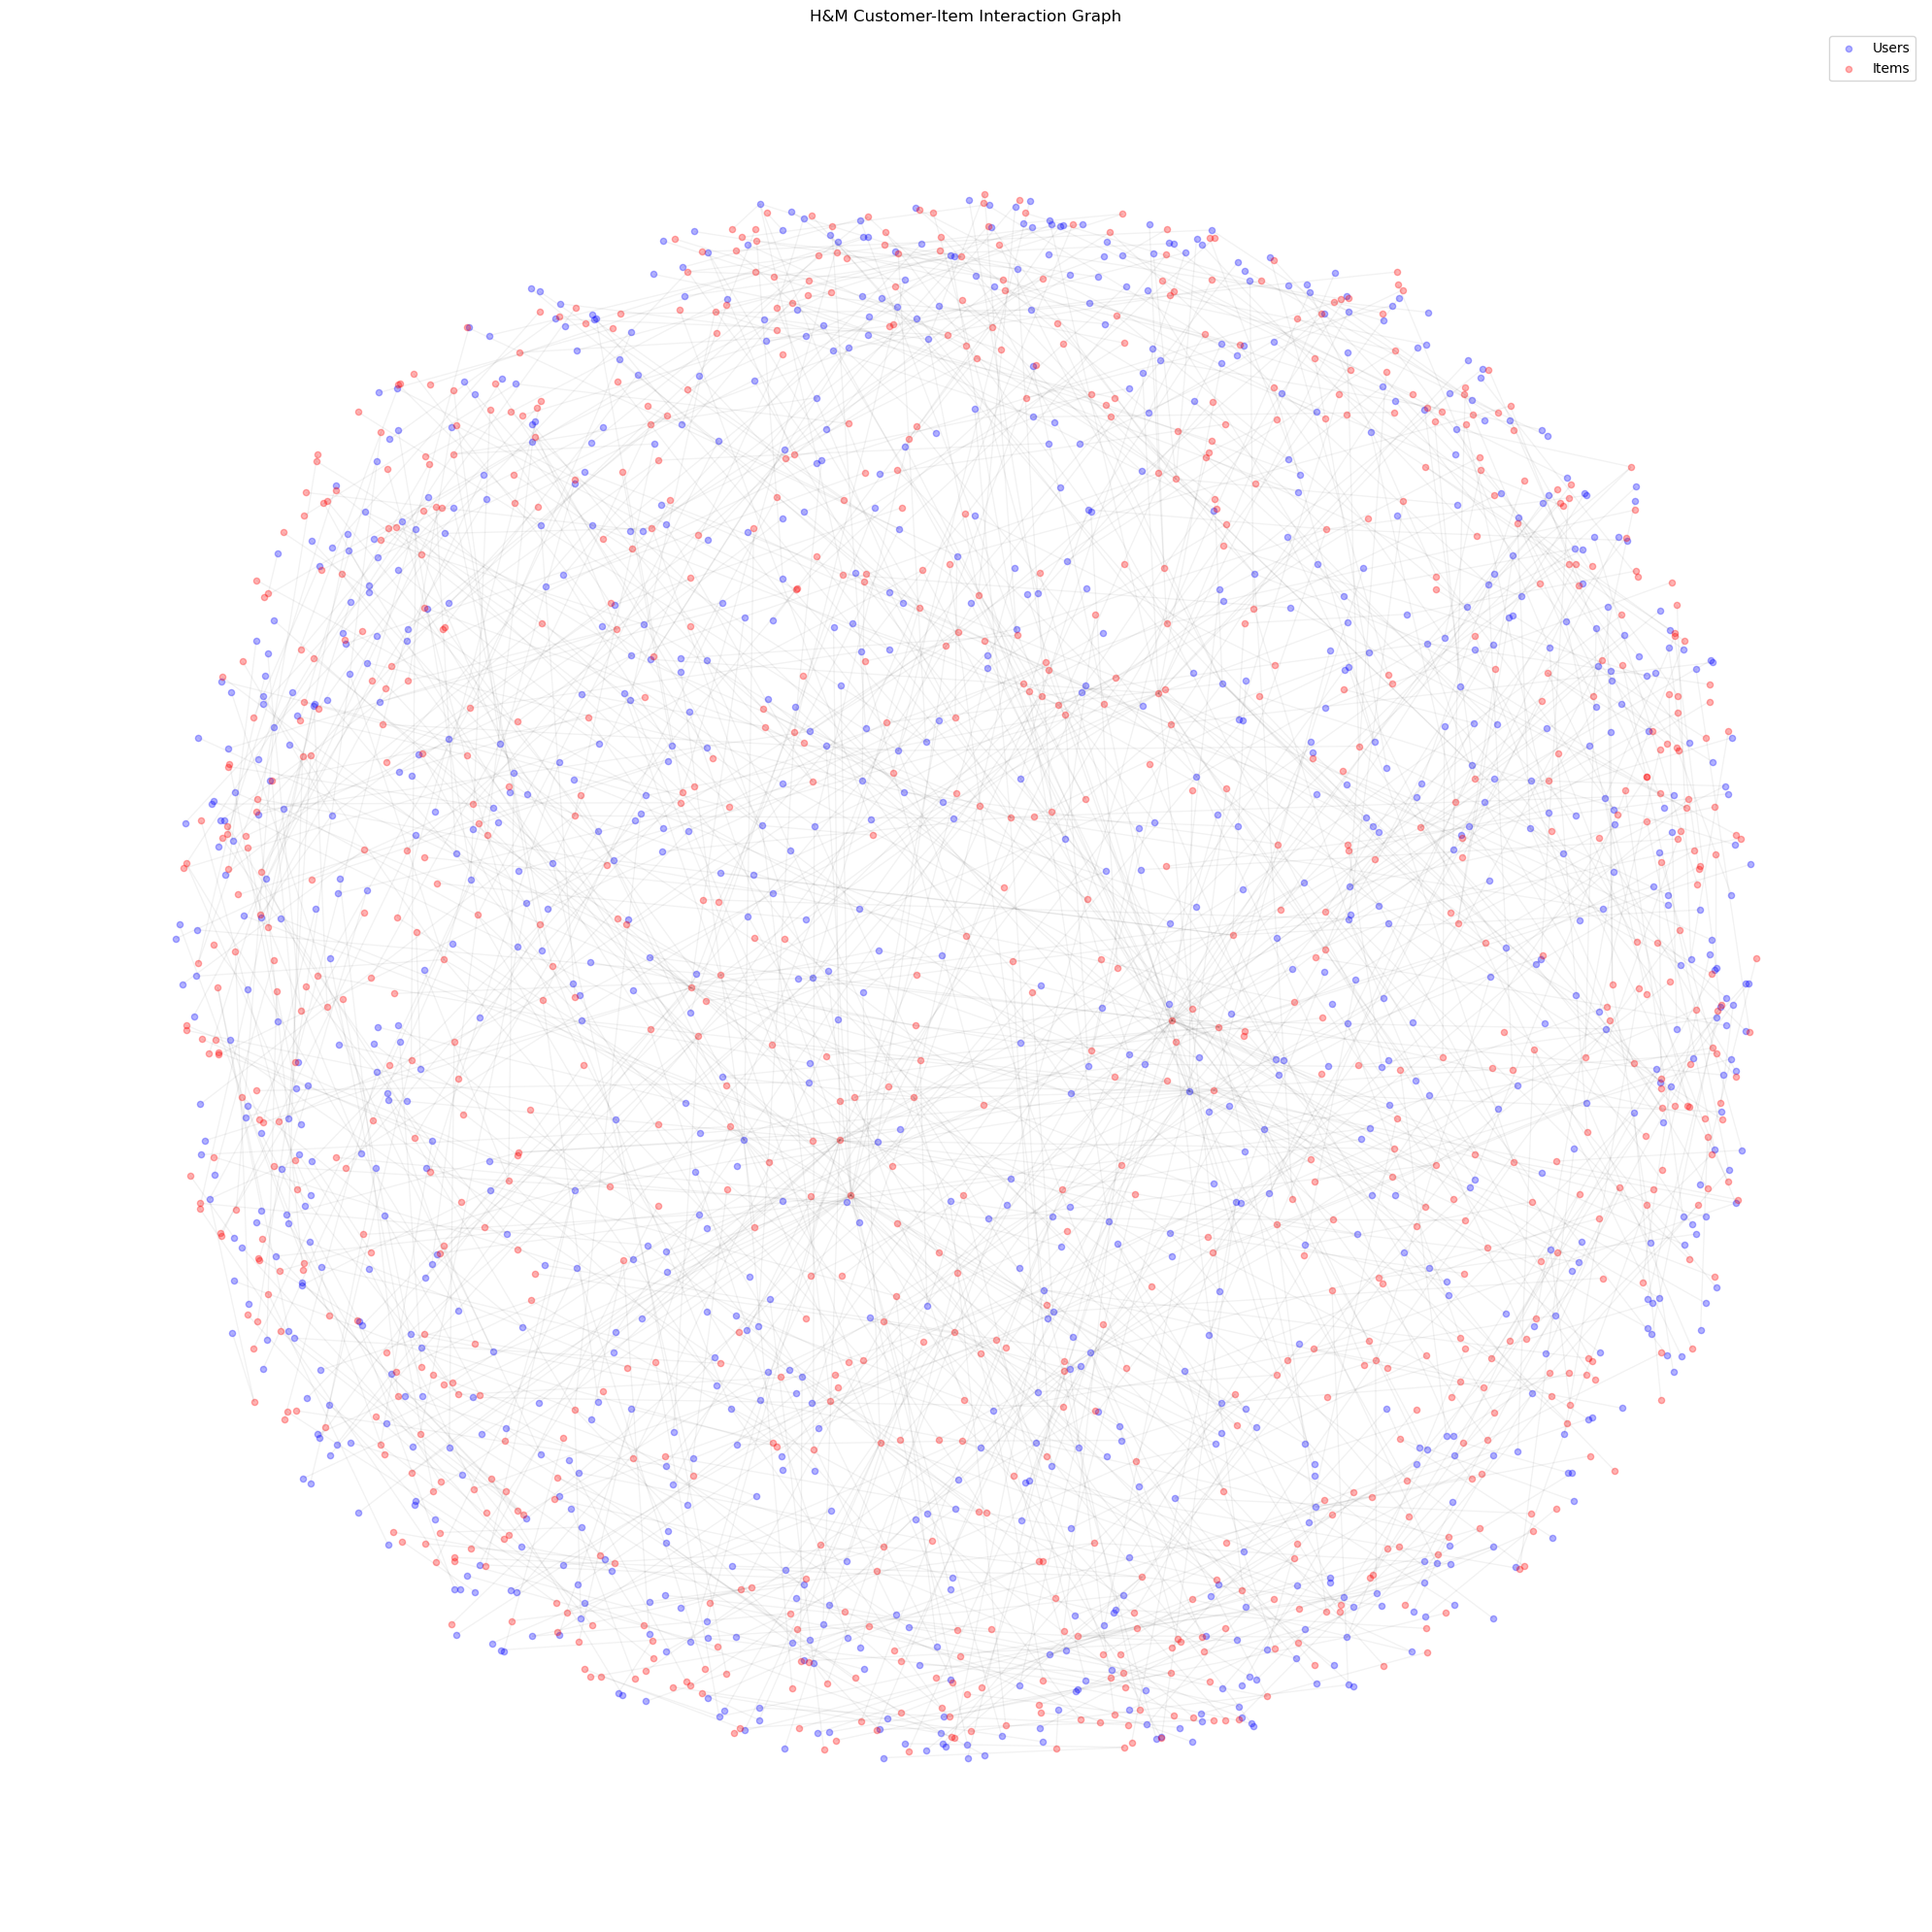

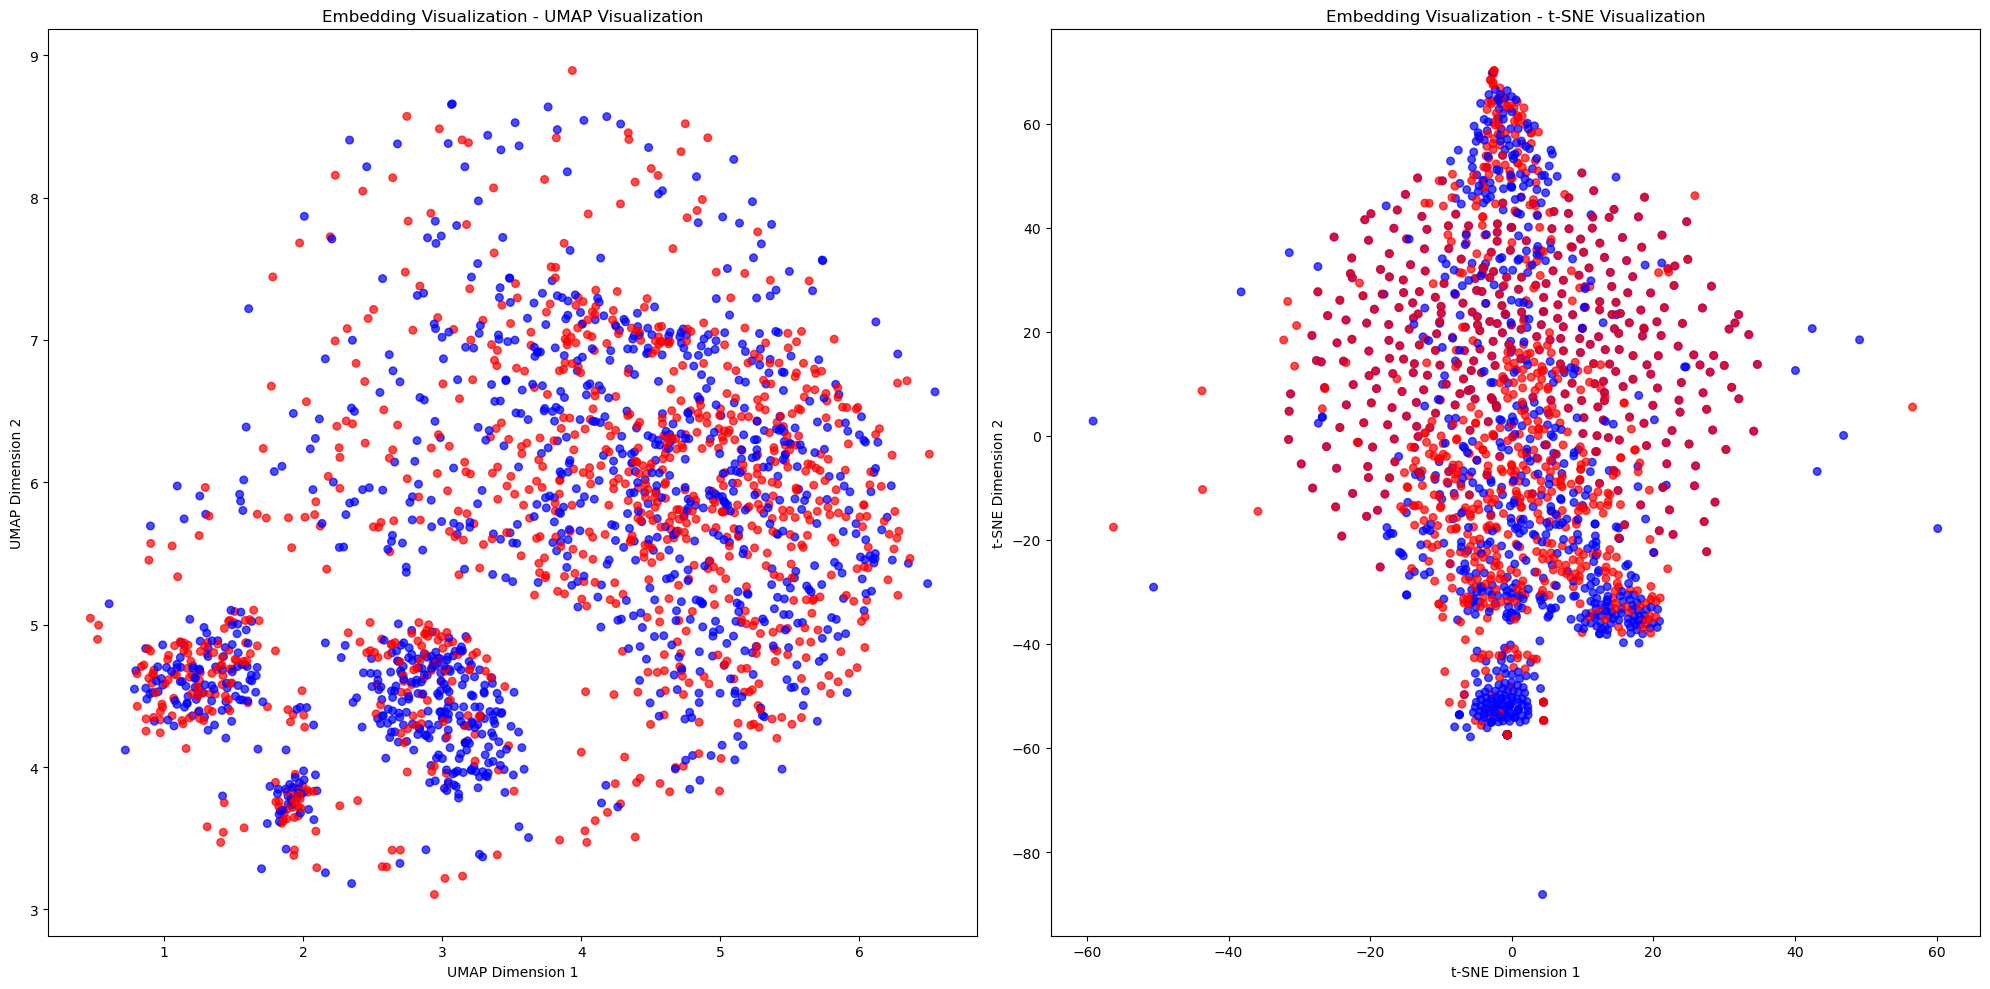

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


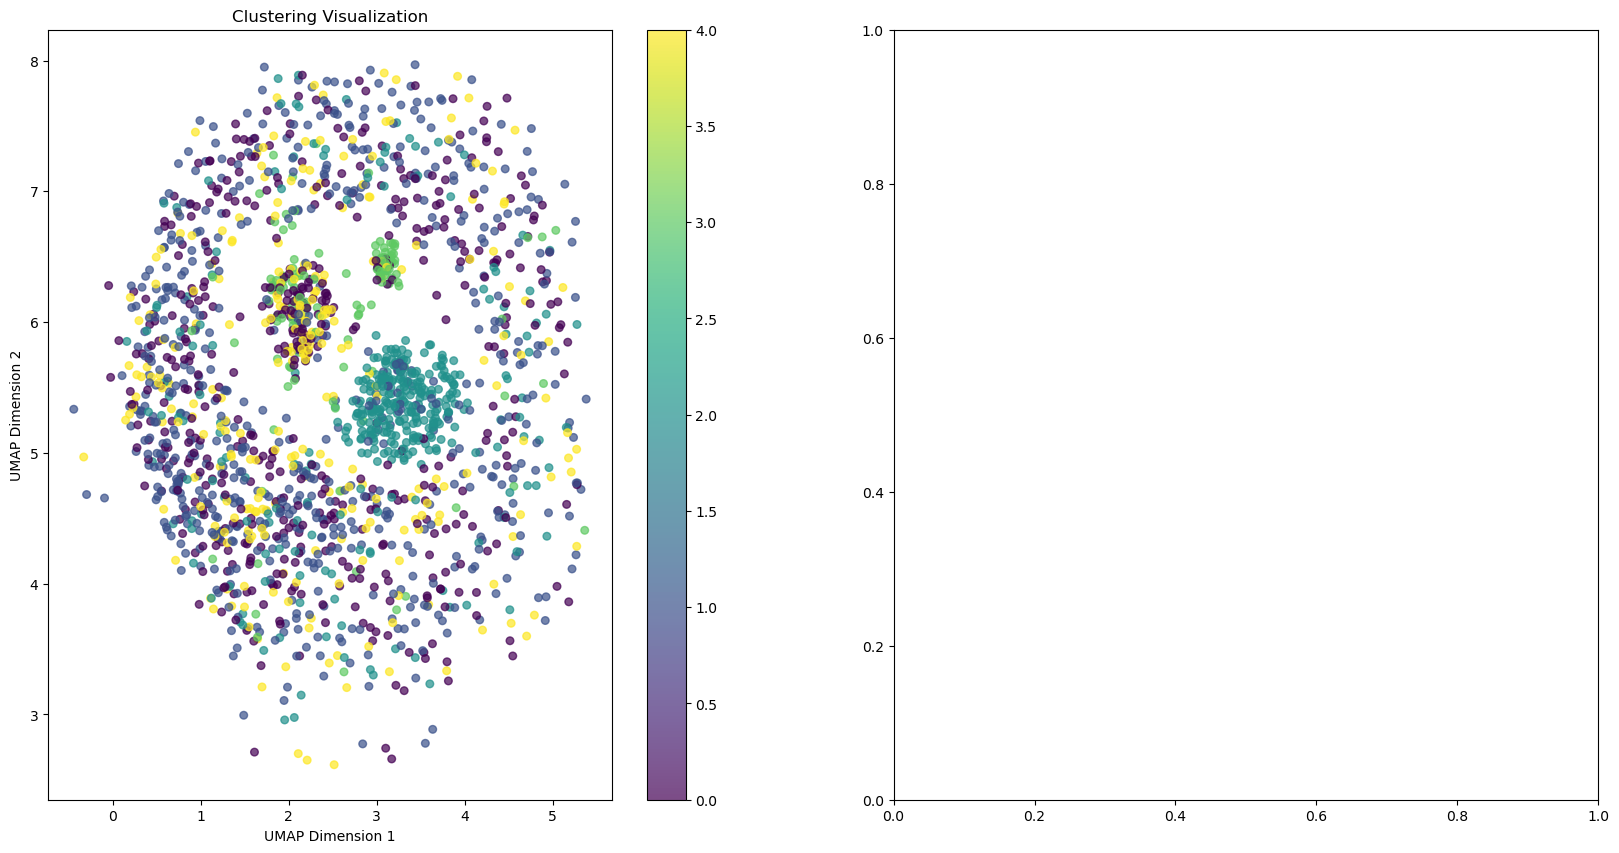

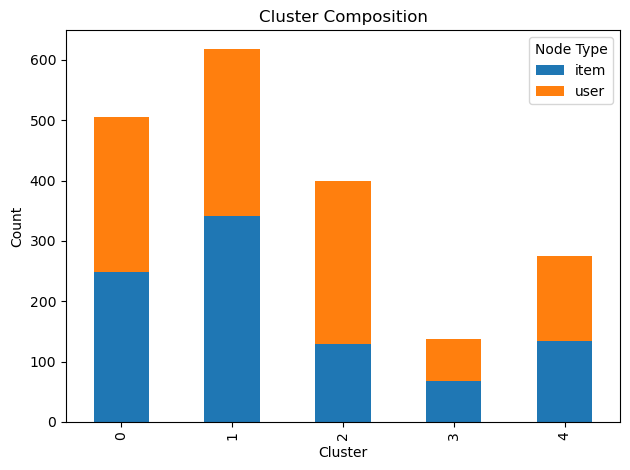

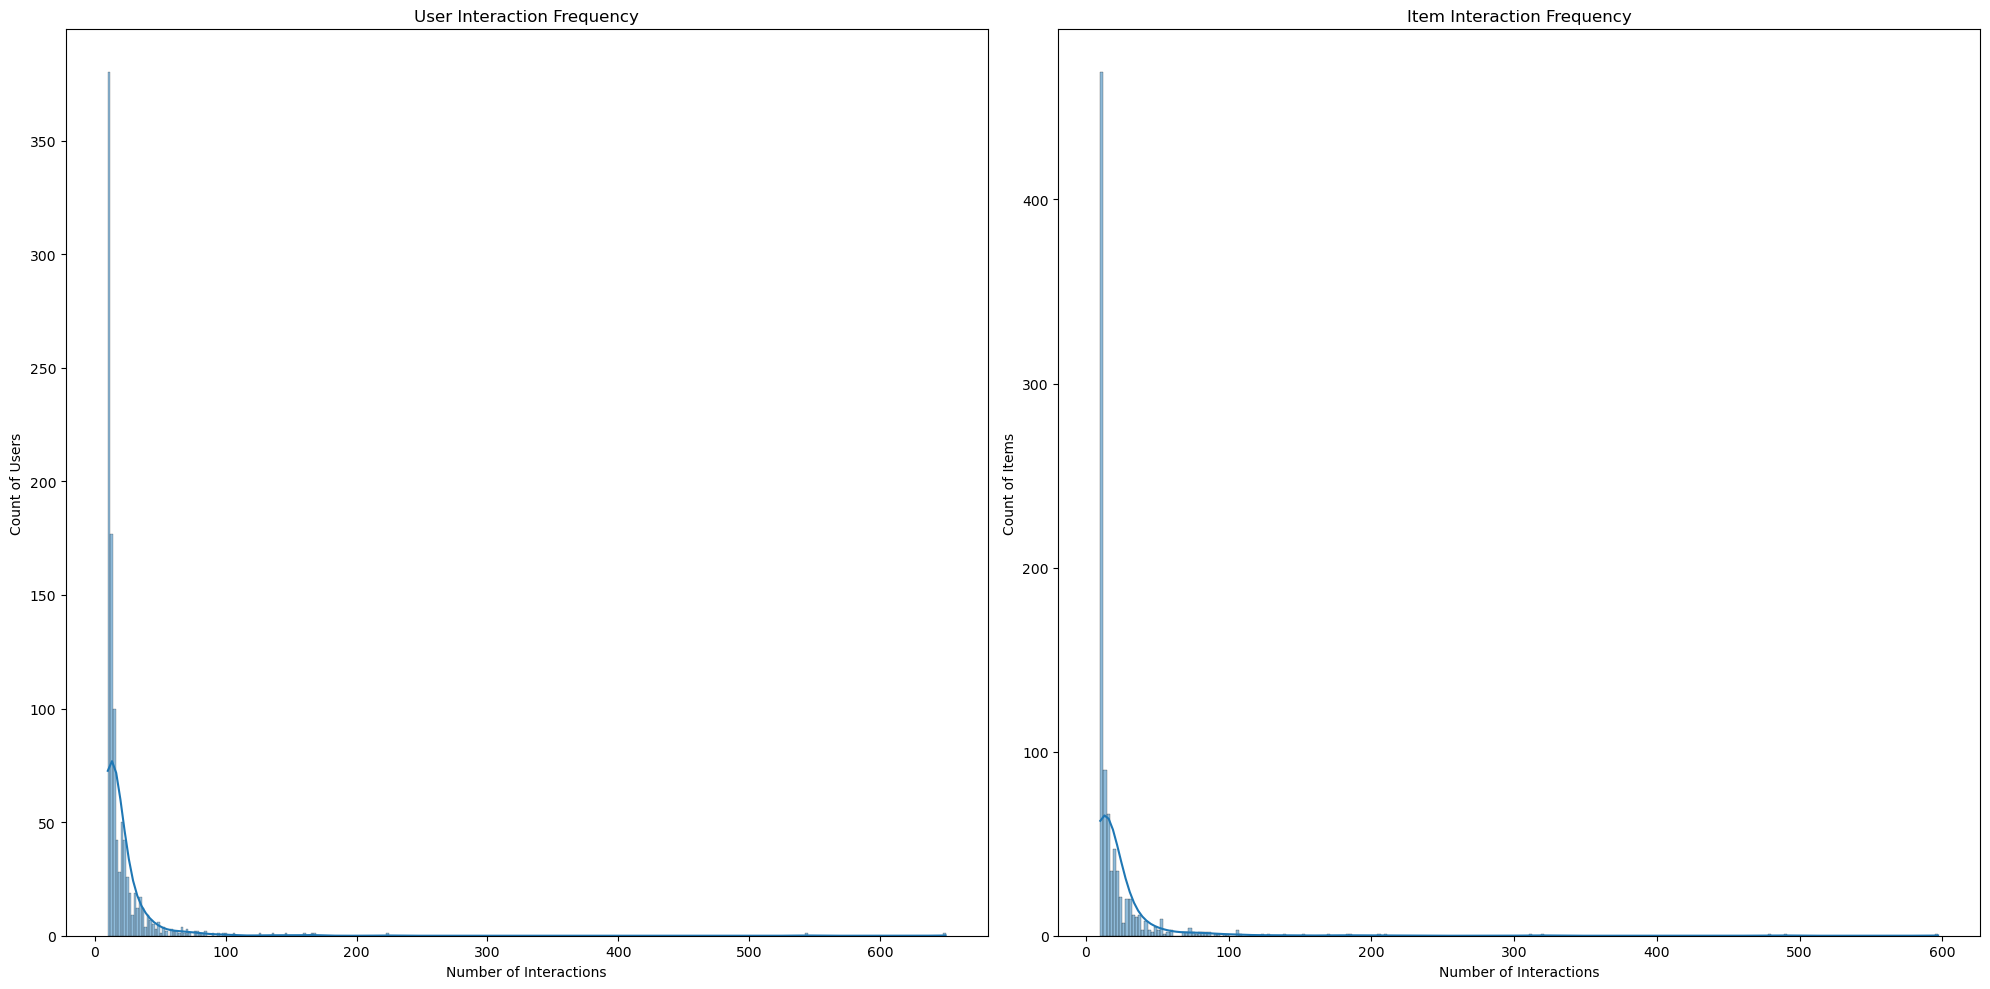

Cluster Composition:
col_0  item  user
row_0            
0       249   257
1       342   276
2       129   270
3        68    69
4       134   141


In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import torch
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap.umap_ as umap

def visualize_graph_structure(G):
    """
    Visualize the overall graph structure
    """
    plt.figure(figsize=(20, 20))
    
    # Separate user and item nodes
    users = [node for node, data in G.nodes(data=True) if data.get('type') == 'user']
    items = [node for node, data in G.nodes(data=True) if data.get('type') == 'item']
    
    # Custom layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Draw users in blue, items in red
    nx.draw_networkx_nodes(G, pos, nodelist=users, node_color='blue', 
                            node_size=20, alpha=0.3, label='Users')
    nx.draw_networkx_nodes(G, pos, nodelist=items, node_color='red', 
                            node_size=20, alpha=0.3, label='Items')
    
    # Draw edges with low alpha
    nx.draw_networkx_edges(G, pos, alpha=0.05)
    
    plt.title('H&M Customer-Item Interaction Graph')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_embeddings(embeddings, GraphTravel_HM, title='Embedding Visualization'):
    """
    Visualize embeddings using UMAP and t-SNE
    """
    # Convert embeddings to numpy array
    embed_array = np.array(list(embeddings.values()))
    nodes = list(embeddings.keys())
    
    # Determine node types
    node_types = []
    for node in nodes:
        if node in set(GraphTravel_HM['customer_id_mapped']):
            node_types.append('user')
        else:
            node_types.append('item')
    
    # UMAP Visualization
    plt.figure(figsize=(20, 10))
    
    # UMAP subplot
    plt.subplot(121)
    reducer_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
    embedding_umap = reducer_umap.fit_transform(embed_array)
    
    # Color mapping
    color_map = {'user': 'blue', 'item': 'red'}
    colors = [color_map[t] for t in node_types]
    
    scatter = plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], 
                          c=colors, alpha=0.7, s=30)
    plt.title(f'{title} - UMAP Visualization')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    
    # t-SNE Visualization
    plt.subplot(122)
    reducer_tsne = TSNE(n_components=2, random_state=42)
    embedding_tsne = reducer_tsne.fit_transform(embed_array)
    
    scatter = plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], 
                          c=colors, alpha=0.7, s=30)
    plt.title(f'{title} - t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    
    plt.tight_layout()
    plt.show()

def cluster_analysis(embeddings, GraphTravel_HM, n_clusters=5):
    """
    Perform clustering analysis on embeddings
    """
    # Convert embeddings to numpy array
    embed_array = np.array(list(embeddings.values()))
    nodes = list(embeddings.keys())
    
    # Determine node types
    node_types = []
    for node in nodes:
        if node in set(GraphTravel_HM['customer_id_mapped']):
            node_types.append('user')
        else:
            node_types.append('item')
    
    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embed_array)
    
    # Visualization
    plt.figure(figsize=(20, 10))
    
    # UMAP for clustering visualization
    reducer_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
    embedding_umap = reducer_umap.fit_transform(embed_array)
    
    # Create subplot for cluster visualization
    plt.subplot(121)
    scatter = plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], 
                          c=cluster_labels, cmap='viridis', alpha=0.7, s=30)
    plt.colorbar(scatter)
    plt.title('Clustering Visualization')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    
    # Cluster distribution
    plt.subplot(122)
    cluster_counts = pd.Series(cluster_labels).value_counts()
    cluster_type_counts = pd.crosstab(cluster_labels, node_types)
    
    cluster_type_counts.plot(kind='bar', stacked=True)
    plt.title('Cluster Composition')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title='Node Type')
    
    plt.tight_layout()
    plt.show()
    
    return cluster_labels, cluster_type_counts

def interaction_frequency_analysis(GraphTravel_HM):
    """
    Analyze and visualize interaction frequencies
    """
    # User interaction frequency
    user_interactions = GraphTravel_HM.groupby('customer_id')['article_id'].count()
    
    # Item interaction frequency
    item_interactions = GraphTravel_HM.groupby('article_id')['customer_id'].count()
    
    # Visualization
    plt.figure(figsize=(20, 10))
    
    # User interactions
    plt.subplot(121)
    sns.histplot(user_interactions, kde=True)
    plt.title('User Interaction Frequency')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Count of Users')
    
    # Item interactions
    plt.subplot(122)
    sns.histplot(item_interactions, kde=True)
    plt.title('Item Interaction Frequency')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Count of Items')
    
    plt.tight_layout()
    plt.show()

def main():
    articles_path = "../input/h-and-m-personalized-fashion-recommendations/articles.csv"
    customers_path = "../input/h-and-m-personalized-fashion-recommendations/customers.csv"
    transactions_path = "../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv"

    # Load and preprocess data
    GraphTravel_HM, item_name_mapping = load_and_preprocess_data(
        articles_path, customers_path, transactions_path
    )
    G = create_interaction_graph(GraphTravel_HM)
    
    # Visualize graph structure
    visualize_graph_structure(G)
    
    # Generate embeddings
    input_dim = len(G.nodes())
    hidden_dim = 128
    output_dim = 128
    embeddings = generate_embeddings(G, input_dim, hidden_dim, output_dim)
    
    # Visualize embeddings
    visualize_embeddings(embeddings, GraphTravel_HM)
    
    # Cluster analysis
    cluster_labels, cluster_type_counts = cluster_analysis(embeddings, GraphTravel_HM)
    
    # Interaction frequency analysis
    interaction_frequency_analysis(GraphTravel_HM)
    
    # Print cluster composition
    print("Cluster Composition:")
    print(cluster_type_counts)

if __name__ == "__main__":
    main()

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import cosine_similarity


# Data Loading and Preprocessing
def load_and_preprocess_data(articles_path, transactions_path):
    articles = pd.read_csv(articles_path)
    transactions = pd.read_csv(transactions_path)

    # Convert dates to datetime
    transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

    # Split data into train and test based on date
    last_month = transactions['t_dat'].max().replace(day=1)
    train_data = transactions[transactions['t_dat'] < last_month]
    test_data = transactions[transactions['t_dat'] >= last_month]

    # Filter items and users with sufficient interactions in the training set
    item_freq = train_data.groupby('article_id')['customer_id'].nunique()
    user_freq = train_data.groupby('customer_id')['article_id'].nunique()

    items = item_freq[item_freq >= 100].index
    users = user_freq[user_freq >= 100].index

    train_data = train_data[
        train_data['article_id'].isin(items) & 
        train_data['customer_id'].isin(users)
    ]

    # Calculate interaction frequency for train data
    freq = train_data.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')
    GraphTravel_HM = train_data.merge(freq, on=['customer_id', 'article_id'], how='left')
    GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

    # Create mappings
    unique_customer_ids = GraphTravel_HM['customer_id'].unique()
    customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
    GraphTravel_HM['customer_id_mapped'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

    # Create item name mapping
    item_name_mapping = dict(zip(articles['article_id'], articles['prod_name']))

    return GraphTravel_HM, test_data, item_name_mapping


# Create Interaction Graph
def create_interaction_graph(GraphTravel_HM):
    G = nx.Graph()
    for _, row in GraphTravel_HM.iterrows():
        G.add_node(row['customer_id_mapped'], type='user')
        G.add_node(row['article_id'], type='item')
        G.add_edge(row['customer_id_mapped'], row['article_id'], weight=row['frequency'])
    return G


# Recommendation Evaluation
def evaluate_recommendations(test_data, embeddings, item_name_mapping, top_k=25):
    # Map customer_id to the same mapping used in training
    test_data['customer_id_mapped'] = test_data['customer_id'].map(customer_id_mapping)

    total_correct = 0
    total_users = 0

    for customer_id, group in test_data.groupby('customer_id_mapped'):
        if customer_id not in embeddings:
            continue
        user_embedding = embeddings[customer_id]
        purchased_items = group['article_id'].unique()

        # Rank items by similarity
        similarities = []
        for item_id in set(test_data['article_id']):
            if item_id in embeddings:
                item_embedding = embeddings[item_id]
                similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
                similarities.append((item_id, similarity))

        # Get top K recommendations
        recommendations = [item for item, _ in sorted(similarities, key=lambda x: x[1], reverse=True)[:top_k]]

        # Calculate correct predictions
        correct_predictions = len(set(recommendations) & set(purchased_items))
        total_correct += correct_predictions
        total_users += 1

    # Calculate average precision
    avg_precision = total_correct / (total_users * top_k)
    print(f"Average Precision: {avg_precision:.4f}")
    return avg_precision


# Main Execution
def main():
    articles_path = "../input/h-and-m-personalized-fashion-recommendations/articles.csv"
    transactions_path = "../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv"

    # Load and preprocess data
    GraphTravel_HM, test_data, item_name_mapping = load_and_preprocess_data(
        articles_path, transactions_path
    )

    # Create interaction graph
    G = create_interaction_graph(GraphTravel_HM)

    # Generate embeddings
    input_dim = len(G.nodes())
    hidden_dim = 128
    output_dim = 128
    embeddings = generate_embeddings(G, input_dim, hidden_dim, output_dim)

    # Evaluate recommendations
    evaluate_recommendations(test_data, embeddings, item_name_mapping, top_k=25)


if __name__ == "__main__":
    main()


Average Precision: 0.0036
